In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [2]:
# Load the dataset
data = pd.read_csv("FuelConsumption.csv")

# Display the first few rows of the dataframe
data.head(5)

,Year,MAKE,MODEL,VEHICLE CLASS,ENGINE SIZE,CYLINDERS,TRANSMISSION,FUEL,FUEL CONSUMPTION,COEMISSIONS
0,2000,ACURA,1.6EL,COMPACT,1.6,4,A4,X,10.5,216
1,2000,ACURA,1.6EL,COMPACT,1.6,4,M5,X,9.8,205
2,2000,ACURA,3.2TL,MID-SIZE,3.2,6,AS5,Z,13.7,265
3,2000,ACURA,3.5RL,MID-SIZE,3.5,6,A4,Z,15.0,301
4,2000,ACURA,INTEGRA,SUBCOMPACT,1.8,4,A4,X,11.4,230


Next Step is to clean the dataset. 

In [3]:
# Check for missing values
print("Missing values in each column:\n", data.isnull().sum())

# Drop rows with any missing values if there are any
data.dropna(inplace=True)

# Check for duplicates
print("Number of duplicate rows:", data.duplicated().sum())

# Remove duplicates if there are any
data.drop_duplicates(inplace=True)

# Reset index after dropping rows
data.reset_index(drop=True, inplace=True)


Missing values in each column:
 Year                0
MAKE                0
MODEL               0
VEHICLE CLASS       0
ENGINE SIZE         0
CYLINDERS           0
TRANSMISSION        0
FUEL                0
FUEL CONSUMPTION    0
COEMISSIONS         0
dtype: int64
Number of duplicate rows: 1


In [4]:
#Lets have a quick look at the data to see hwat we're working with
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 638 entries, 0 to 637
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Year              638 non-null    int64  
 1   MAKE              638 non-null    object 
 2   MODEL             638 non-null    object 
 3   VEHICLE CLASS     638 non-null    object 
 4   ENGINE SIZE       638 non-null    float64
 5   CYLINDERS         638 non-null    int64  
 6   TRANSMISSION      638 non-null    object 
 7   FUEL              638 non-null    object 
 8   FUEL CONSUMPTION  638 non-null    float64
 9   COEMISSIONS       638 non-null    int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 50.0+ KB


,Year,ENGINE SIZE,CYLINDERS,FUEL CONSUMPTION,COEMISSIONS
count,638.0,638.000000,638.000000,638.000000,638.000000
mean,2000.0,3.264577,5.802508,14.705956,296.642633
std,0.0,1.231634,1.624535,3.303962,65.420203
min,2000.0,1.000000,3.000000,4.900000,104.000000
25%,2000.0,2.200000,4.000000,12.500000,253.000000
50%,2000.0,3.000000,6.000000,14.400000,288.000000
75%,2000.0,4.300000,6.000000,16.600000,343.000000
max,2000.0,8.000000,12.000000,30.200000,582.000000


In [5]:
print(data.columns)

Index(['Year', 'MAKE', 'MODEL', 'VEHICLE CLASS', 'ENGINE SIZE', 'CYLINDERS',
       'TRANSMISSION', 'FUEL', 'FUEL CONSUMPTION', 'COEMISSIONS '],
      dtype='object')


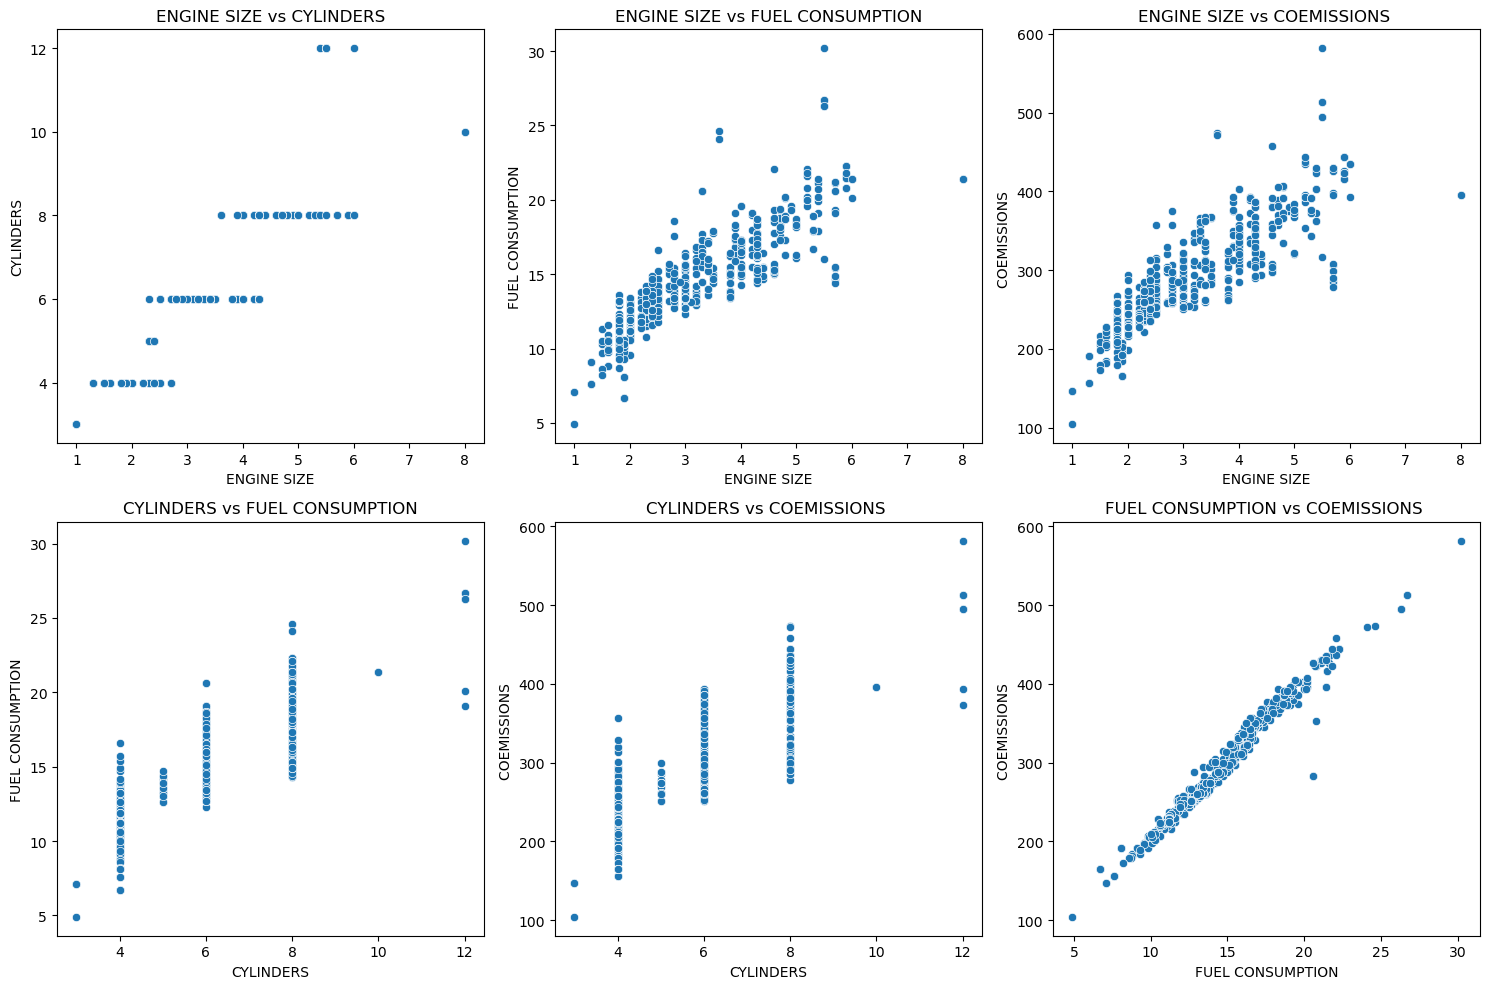

In [6]:
numerical_cols = ['ENGINE SIZE', 'CYLINDERS', 'FUEL CONSUMPTION', 'COEMISSIONS ']

# Setting up the figure size and plot grid
plt.figure(figsize=(15, 10))
plot_count = 1  # Start counting plots from 1

# Calculate the total number of plots needed
num_plots = len(numerical_cols) * (len(numerical_cols) - 1) // 2

# Determine the number of rows/columns required
n_cols = 3  # You can adjust the number of columns based on your preference
n_rows = num_plots // n_cols + (num_plots % n_cols > 0)

for i in range(len(numerical_cols)):
    for j in range(i + 1, len(numerical_cols)):
        ax = plt.subplot(n_rows, n_cols, plot_count)
        sns.scatterplot(x=data[numerical_cols[i]], y=data[numerical_cols[j]], ax=ax)
        plt.title(f'{numerical_cols[i]} vs {numerical_cols[j]}')
        plot_count += 1  # Increment the plot counter

plt.tight_layout()
plt.show()

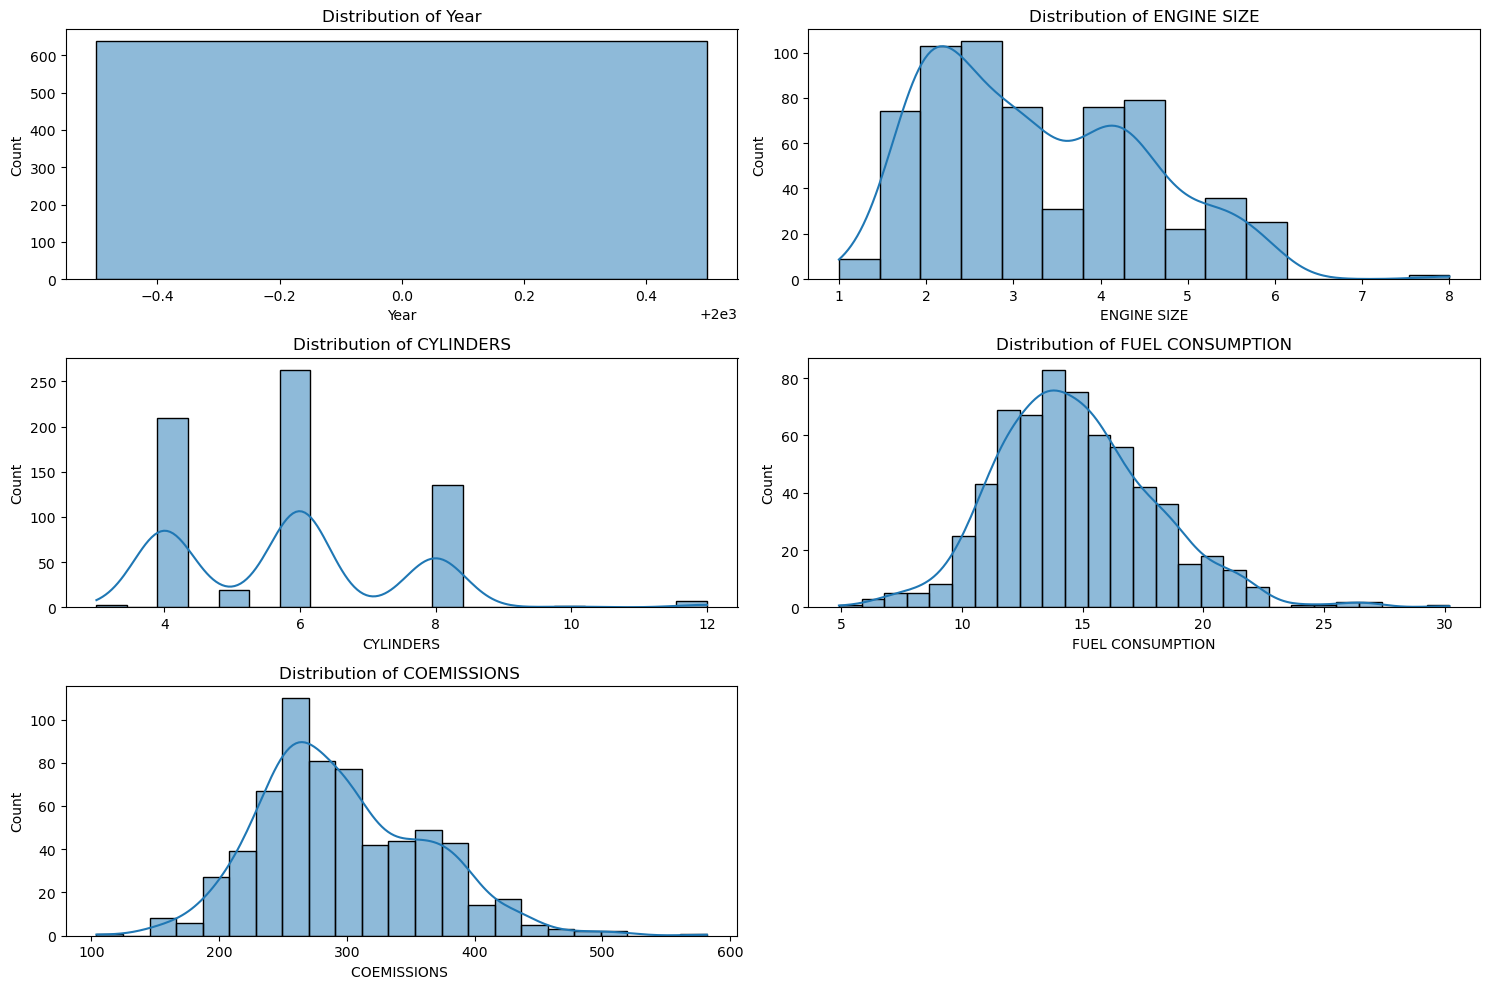

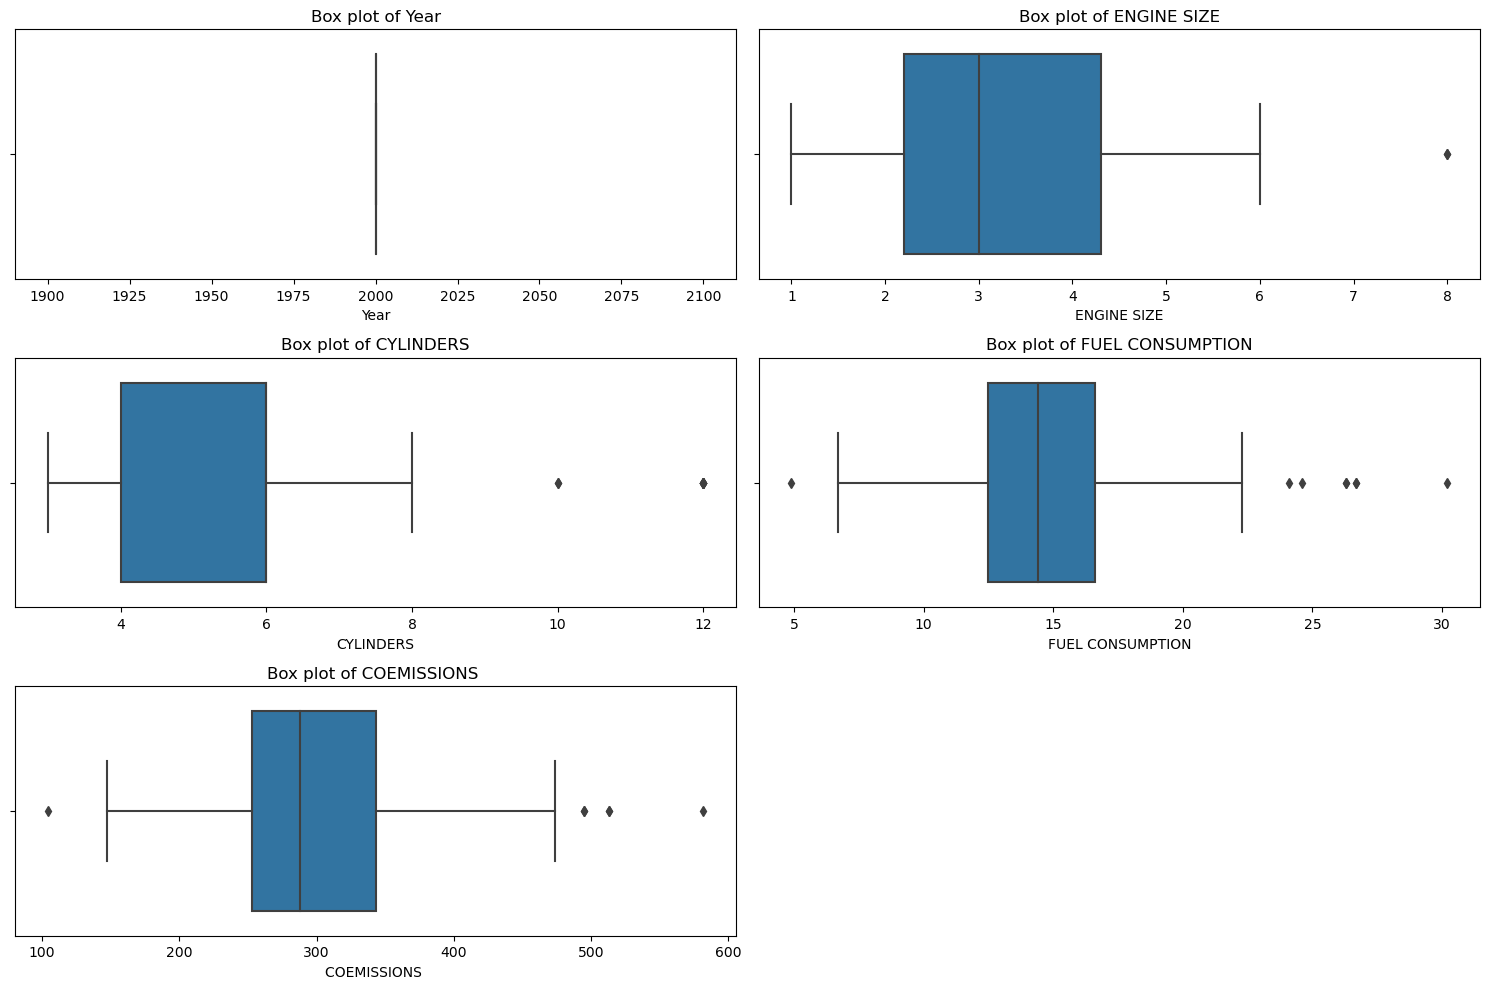

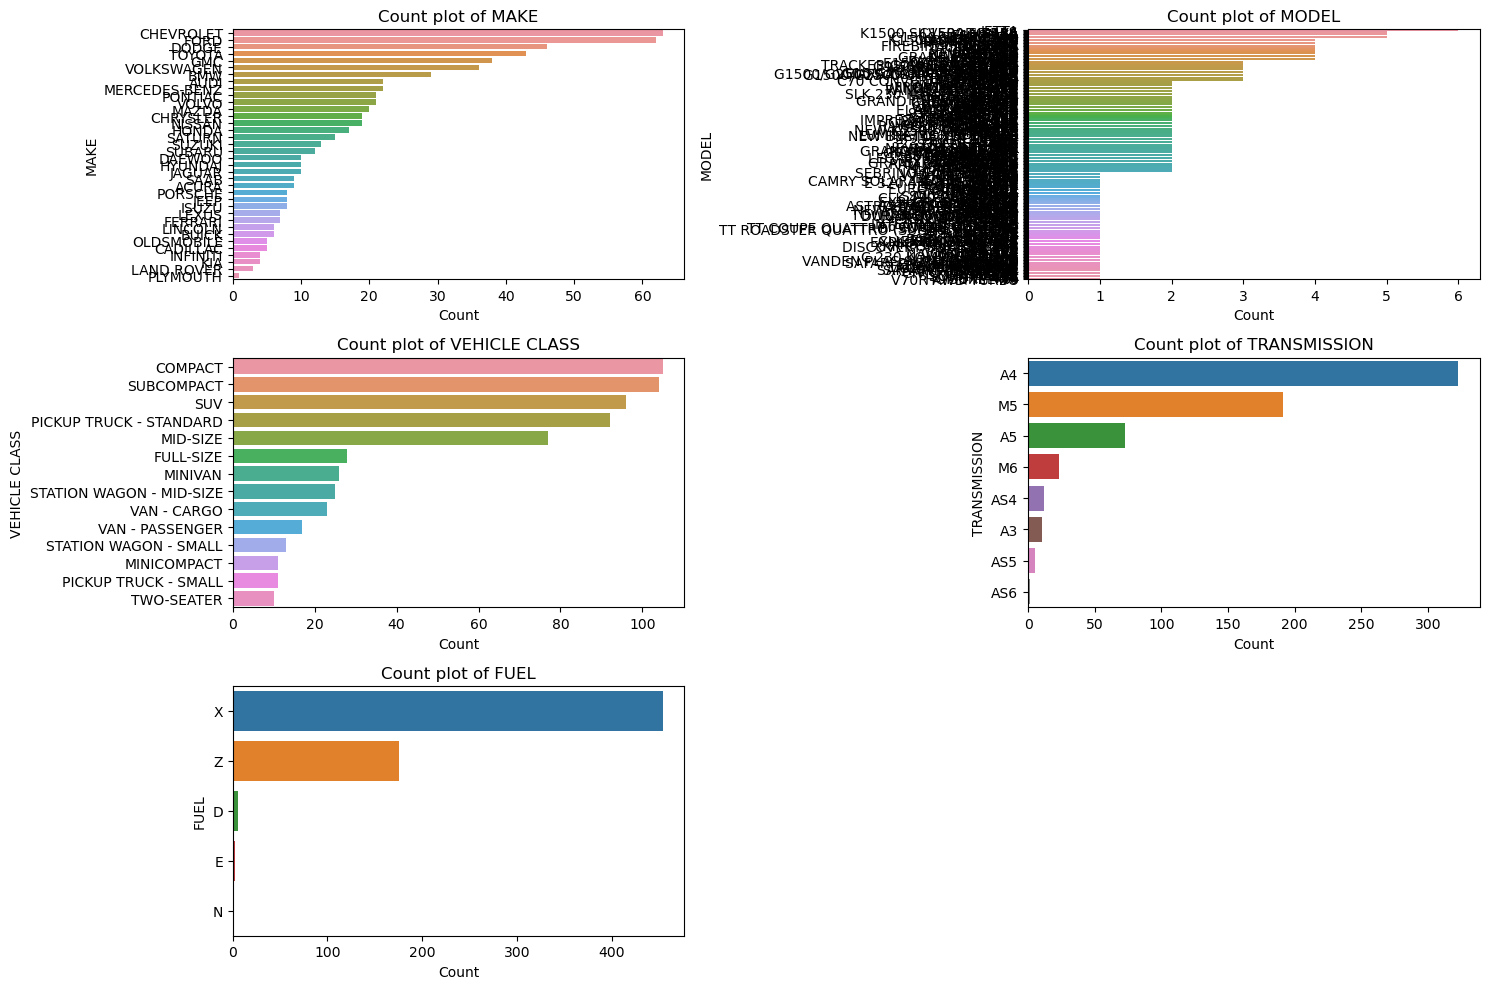

In [7]:
# Select numerical and categorical columns
numerical_cols = data.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = data.select_dtypes(exclude=[np.number]).columns.tolist()

# Plotting histograms for numerical columns
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 2, i + 1)
    sns.histplot(data[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Plotting box plots for numerical columns
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 2, i + 1)
    sns.boxplot(x=data[col])
    plt.title(f'Box plot of {col}')
plt.tight_layout()
plt.show()

# Plotting count plots for categorical columns
plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_cols):
    plt.subplot(3, 2, i + 1)
    sns.countplot(y=data[col], order=data[col].value_counts().index)
    plt.title(f'Count plot of {col}')
    plt.xlabel('Count')
    plt.ylabel(col)
plt.tight_layout()
plt.show()

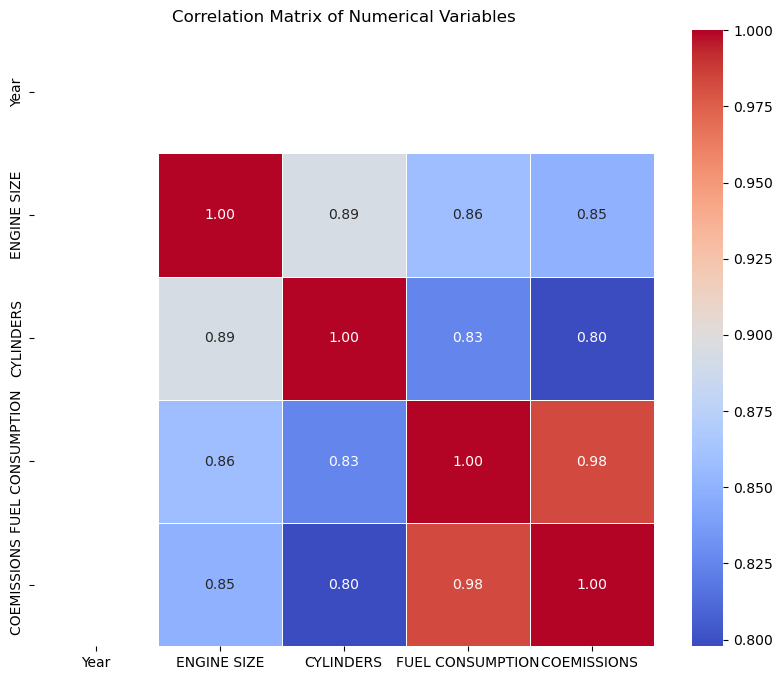

In [8]:
# Calculating and displaying the correlation matrix
correlation_matrix = data[numerical_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

In [ ]:
categorical_cols = [c for c in data.columns if c not in numerical_cols]
categorical_cols.remove('MODEL')
categorical_cols

In [9]:
def get_one_hot_df(df, col):

    return (
        data[[col]]
        .drop_duplicates()
        .reset_index(drop=True)
        .reset_index()
        .rename(columns={'index': f'feat_{col}'})
    )

for c in categorical_cols:

    data = pd.merge(
        data,
        get_one_hot_df(data, c),
        on=c,
        how='left',
    )

data.head()


,Year,MAKE,MODEL,VEHICLE CLASS,ENGINE SIZE,CYLINDERS,TRANSMISSION,FUEL,FUEL CONSUMPTION,COEMISSIONS,feat_MAKE,feat_MODEL,feat_VEHICLE CLASS,feat_TRANSMISSION,feat_FUEL
0,2000,ACURA,1.6EL,COMPACT,1.6,4,A4,X,10.5,216,0,0,0,0,0
1,2000,ACURA,1.6EL,COMPACT,1.6,4,M5,X,9.8,205,0,0,0,1,0
2,2000,ACURA,3.2TL,MID-SIZE,3.2,6,AS5,Z,13.7,265,0,1,1,2,1
3,2000,ACURA,3.5RL,MID-SIZE,3.5,6,A4,Z,15.0,301,0,2,1,0,1
4,2000,ACURA,INTEGRA,SUBCOMPACT,1.8,4,A4,X,11.4,230,0,3,2,0,0


In [10]:
feat_cols_to_rename = [c for c in numerical_cols if c not in ['COEMISSIONS ', 'Year']]

data = data.rename(
    columns={
        c: 'feat_' + c
        for c in feat_cols_to_rename
    }
)

data.head()

,Year,MAKE,MODEL,VEHICLE CLASS,feat_ENGINE SIZE,feat_CYLINDERS,TRANSMISSION,FUEL,feat_FUEL CONSUMPTION,COEMISSIONS,feat_MAKE,feat_MODEL,feat_VEHICLE CLASS,feat_TRANSMISSION,feat_FUEL
0,2000,ACURA,1.6EL,COMPACT,1.6,4,A4,X,10.5,216,0,0,0,0,0
1,2000,ACURA,1.6EL,COMPACT,1.6,4,M5,X,9.8,205,0,0,0,1,0
2,2000,ACURA,3.2TL,MID-SIZE,3.2,6,AS5,Z,13.7,265,0,1,1,2,1
3,2000,ACURA,3.5RL,MID-SIZE,3.5,6,A4,Z,15.0,301,0,2,1,0,1
4,2000,ACURA,INTEGRA,SUBCOMPACT,1.8,4,A4,X,11.4,230,0,3,2,0,0


In [26]:
dont_include = ['feat_FUEL CONSUMPTION']
#dont_include = []
feat_cols = [c for c in data.columns if 'feat' in c and c not in dont_include]

# Define features and target
X = data[feat_cols]
y = data['COEMISSIONS ']  # Update this if the column name is different

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [27]:
print('Size of X_train', X_train.shape)
print('Size of X_test', X_test.shape)

Size of X_train (510, 7)
Size of X_test (128, 7)


In [28]:
# Initialize the models
lr = LinearRegression()
rf = RandomForestRegressor(random_state=42)
gb = GradientBoostingRegressor(random_state=42)

# Train the models
lr.fit(X_train, y_train)
rf.fit(X_train, y_train)
gb.fit(X_train, y_train)

# Predict on testing set
lr_pred = lr.predict(X_test)
rf_pred = rf.predict(X_test)
gb_pred = gb.predict(X_test)

# Evaluate the models
lr_mse = mean_squared_error(y_test, lr_pred)
rf_mse = mean_squared_error(y_test, rf_pred)
gb_mse = mean_squared_error(y_test, gb_pred)

print(f'Linear Regression MSE: {lr_mse}')
print(f'Random Forest MSE: {rf_mse}')
print(f'Gradient Boosting MSE: {gb_mse}')

Linear Regression MSE: 1014.4668052589809
Random Forest MSE: 375.48956953125
Gradient Boosting MSE: 378.583974344598


In [29]:
# Parameter grid for Gradient Boosting
# param_grid = {
#     'n_estimators': [50, 100, 200, 300, 500],
#     'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
#     'subsample': [0.5, 0.7, 0.9, 1.0],
#     'max_depth': [2, 3, 4, 5, 6]
# }

param_grid = {
    'n_estimators': [10, 20, 30, 50, 100, 150],
    'learning_rate': [0.2, 0.1, 0.05, 1e-2, 1e-3],
    # 'subsample': [0.5, 0.7, 0.9, 1.0],
    'max_depth': [2, 3, 4, 5],
}

# Create a GradientBoostingRegressor object
gb = GradientBoostingRegressor(random_state=42)

# Set up the grid search with 3-fold cross-validation
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (negative MSE):", grid_search.best_score_)

# Get the best model
best_gb = grid_search.best_estimator_

# Evaluate the optimized model on the test set
optimized_pred = best_gb.predict(X_test)
optimized_mse = mean_squared_error(y_test, optimized_pred)
print(f'Optimized Gradient Boosting MSE: {optimized_mse}')


Fitting 3 folds for each of 120 candidates, totalling 360 fits
Best parameters: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 150}
Best cross-validation score (negative MSE): -434.04921279053156
Optimized Gradient Boosting MSE: 262.28585296922097


In [31]:
gb_opt = GradientBoostingRegressor(
    **grid_search.best_params_,
    random_state=42
)

gb_opt.fit(X_train, y_train)
opt_mse = mean_squared_error(y_test, gb_opt.predict(X_test))

print('Optimised MSE on the test set:', opt_mse)

Optimised MSE on the test set: 262.28585296922097


In [32]:
# Print the MSE for comparison
print(f'Optimized Gradient Boosting MSE: {opt_mse}')

# If you want to compare it directly with the initial MSE:
print(f'Initial Gradient Boosting MSE: {gb_mse}')

# Comparing the results
if opt_mse < gb_mse:
    print("The optimized model performs better than the initial model.")
else:
    print("The initial model performed better, or there was no improvement.")


Optimized Gradient Boosting MSE: 262.28585296922097
Initial Gradient Boosting MSE: 378.583974344598
The optimized model performs better than the initial model.


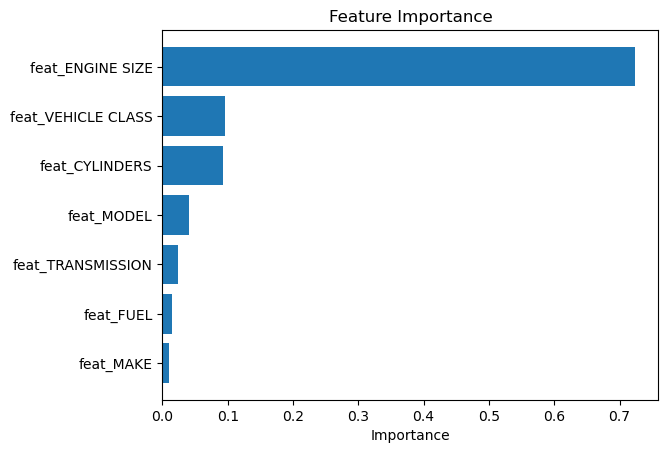

In [33]:
feature_importance = best_gb.feature_importances_
sorted_idx = np.argsort(feature_importance)
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [X_train.columns[i] for i in sorted_idx])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

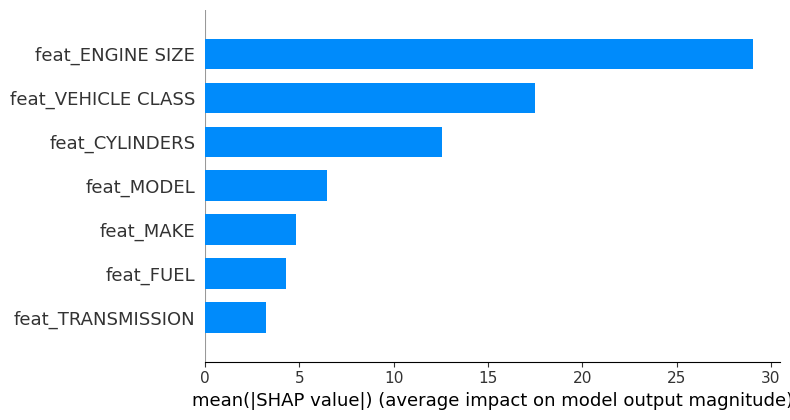

In [37]:
import shap

# Explain the model's predictions using SHAP
explainer = shap.TreeExplainer(gb_opt)
shap_values = explainer.shap_values(X_train)

# Plot summary plot using SHAP values
shap.summary_plot(shap_values, X_train, plot_type="bar")


In [34]:
from sklearn.metrics import mean_absolute_error, r2_score

# Predictions on the test set
y_pred = gb_opt.predict(X_test)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'R-squared (R2): {r2:.2f}')


Mean Absolute Error (MAE): 11.16
R-squared (R2): 0.94


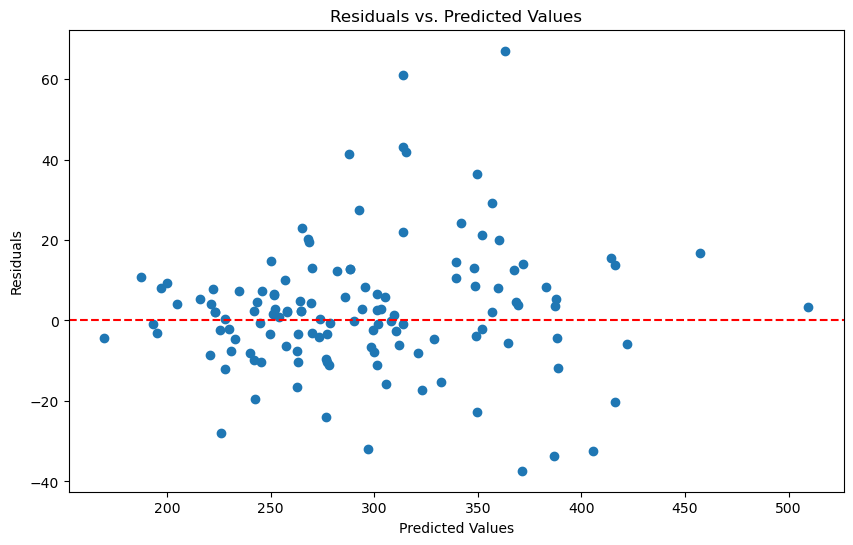

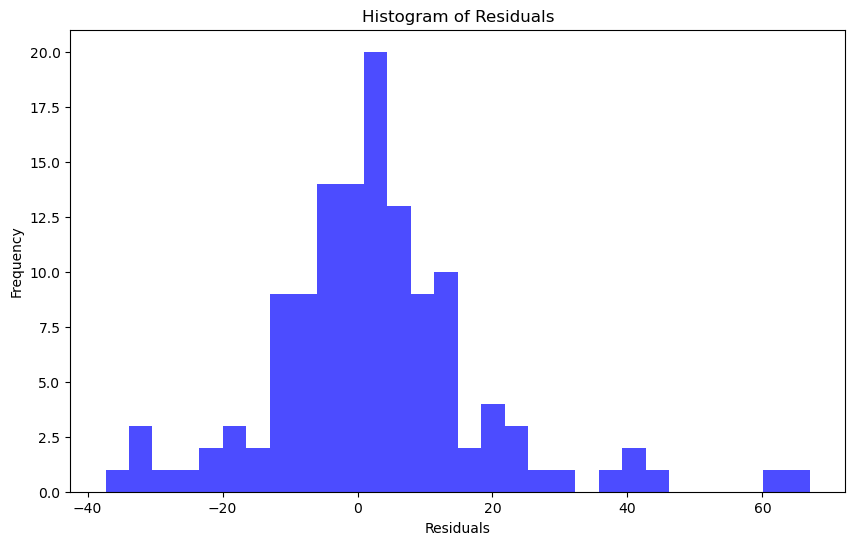

In [35]:
# Calculate residuals
residuals = y_test - y_pred

# Plotting the residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()

# Histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, alpha=0.7, color='blue')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()


In [24]:
# Perform 5-fold cross-validation
cv_r2_scores = cross_val_score(gb_opt, X, y, cv=5, scoring='r2')
cv_mae_scores = cross_val_score(gb_opt, X, y, cv=5, scoring='neg_mean_absolute_error')

print(f'Average R-squared from CV: {cv_r2_scores.mean():.2f}')
print(f'Average MAE from CV: {-cv_mae_scores.mean():.2f}')  # Note: neg_mean_absolute_error returns negative values


Average R-squared from CV: 0.95
Average MAE from CV: 7.67


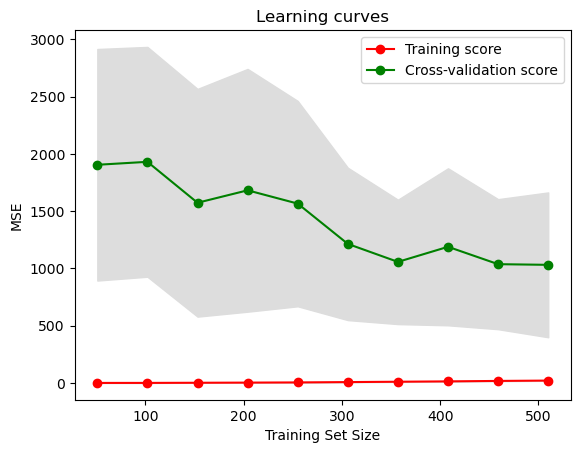

In [36]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(gb_opt, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='neg_mean_squared_error')

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(-train_scores, axis=1)
train_std = np.std(-train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(-test_scores, axis=1)
test_std = np.std(-test_scores, axis=1)

# Plot learning curves
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
plt.title('Learning curves')
plt.xlabel('Training Set Size')
plt.ylabel('MSE')
plt.legend(loc="best")
plt.show()
